# Red neuronal LSTM para predecir niveles del río Orinoco

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split
from keras.api.utils import timeseries_dataset_from_array
import tensorflow as tf
import numpy as np

In [5]:
data = pd.read_csv("data/dataset_combinado.csv")
data.head()

,fecha,ayacucho,caicara,ciudad_bolivar,palua
0,1974/01/01,43.34,24.98,6.89,3.83
1,1974/01/02,43.25,24.88,6.78,3.93
2,1974/01/03,43.14,24.78,6.73,3.75
3,1974/01/04,43.04,24.68,6.68,3.49
4,1974/01/05,42.94,24.58,6.62,3.64


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18683 entries, 0 to 18682
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   fecha           18683 non-null  object 
 1   ayacucho        17983 non-null  float64
 2   caicara         18683 non-null  float64
 3   ciudad_bolivar  18683 non-null  float64
 4   palua           18666 non-null  float64
dtypes: float64(4), object(1)
memory usage: 729.9+ KB


In [7]:
# Eliminar registros con valores nulos
data.dropna(inplace=True)

In [8]:
# Agregar características de estacionalidad
# Convertir la columna 'fecha' en datetime
data['fecha'] = pd.to_datetime(data['fecha'])
data['mes'] = data['fecha'].dt.month
data['dia_del_anio'] = data['fecha'].dt.dayofyear

In [9]:
# Normalizar las nuevas características
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['ayacucho', 'caicara', 'ciudad_bolivar', 'palua', 'mes', 'dia_del_anio']])

In [10]:
# Crear secuencias para predecir múltiples días futuros
sequence_length = 90  # Ventana de entrada
forecast_steps = 10   # Número de días futuros a predecir
batch_size = 16       # Reducir el tamaño del batch si es necesario

In [11]:
# Elegir índice de corte para training y testing (por ejemplo 80% para training)
split_index = int(len(data_scaled) * 0.8)

# Asegurarse de que haya suficientes datos para generar secuencias
if split_index < sequence_length + forecast_steps:
    raise ValueError("El conjunto de datos es demasiado pequeño para generar las secuencias requeridas.")

train_data = data_scaled[:split_index]
test_data = data_scaled[split_index:]

In [12]:
# Crear secuencias para predecir múltiples días futuros
train_dataset = timeseries_dataset_from_array(
    data=train_data,
    targets=np.array([train_data[i:i + forecast_steps, :4] for i in range(sequence_length, len(train_data) - forecast_steps)]),
    sequence_length=sequence_length,
    batch_size=batch_size
)

test_dataset = timeseries_dataset_from_array(
    data=test_data,
    targets=np.array([test_data[i:i + forecast_steps, :4] for i in range(sequence_length, len(test_data) - forecast_steps)]),
    sequence_length=sequence_length,
    batch_size=batch_size
)

In [13]:
# Ajustar el modelo para predecir forecast_steps valores futuros
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(sequence_length, train_data.shape[1])),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),  # Capturar patrones locales
    tf.keras.layers.LSTM(100, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(100),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(forecast_steps * 4),  # Ajustar el número de unidades para que coincida con forecast_steps * 4
    tf.keras.layers.Reshape((forecast_steps, 4))  # Cambiar la forma de la salida a (forecast_steps, 4)
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    loss="mean_squared_error",
    metrics=["mean_absolute_error"]
)

In [14]:
# Entrenar el modelo con más épocas
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=5,  # Incrementar el número de épocas
    batch_size=32,  # Ajustar el tamaño del lote
    verbose=1
)

Epoch 1/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 110s 119ms/step - loss: 0.0156 - mean_absolute_error: 0.0907 - val_loss: 0.0095 - val_mean_absolute_error: 0.0712
Epoch 2/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 102s 115ms/step - loss: 0.0039 - mean_absolute_error: 0.0473 - val_loss: 0.0028 - val_mean_absolute_error: 0.0389
Epoch 3/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 104s 116ms/step - loss: 0.0029 - mean_absolute_error: 0.0407 - val_loss: 0.0021 - val_mean_absolute_error: 0.0333
Epoch 4/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 105s 118ms/step - loss: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285
Epoch 5/5
893/893 ━━━━━━━━━━━━━━━━━━━━ 103s 116ms/step - loss: 0.0021 - mean_absolute_error: 0.0347 - val_loss: 0.0016 - val_mean_absolute_error: 0.0301


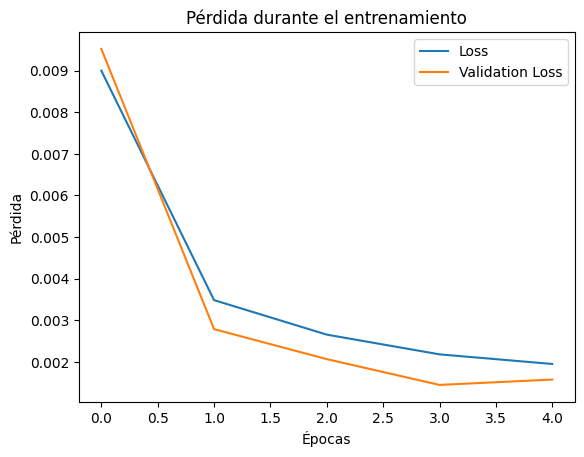

In [15]:
# Graficar la pérdida durante el entrenamiento
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Pérdida durante el entrenamiento")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 793ms/step
Predicciones (10 días x 4 ciudades):
[[40.53590212 22.05354417  3.47764848  1.65203023]
 [40.62851286 21.99233523  3.4044553   1.60401788]
 [40.56158994 22.0707419   3.41937894  1.64735183]
 [40.64760609 21.99747047  3.38542358  1.5507605 ]
 [40.64107786 22.13383347  3.2067014   1.58377768]
 [40.54714547 22.04195779  3.36682427  1.56410303]
 [40.63246064 21.99140672  3.31864773  1.47633769]
 [40.64196179 21.96983786  3.25758503  1.54794755]
 [40.68378233 21.99291715  3.30479176  1.5111083 ]
 [40.67578624 21.9507684   3.25895757  1.4985053 ]]

Valores reales (si están disponibles):
[[44.4  26.5   7.84  3.85]
 [44.48 26.6   7.96  3.89]
 [44.54 26.7   8.07  3.94]
 [44.58 26.8   8.06  3.94]
 [44.6  26.87  8.2   4.1 ]
 [44.57 26.88  8.28  4.3 ]
 [44.55 26.82  8.35  4.27]
 [44.52 26.78  8.37  4.27]
 [44.5  26.68  8.37  4.21]
 [44.45 26.6   8.34  4.27]]


<Figure size 1000x600 with 0 Axes>

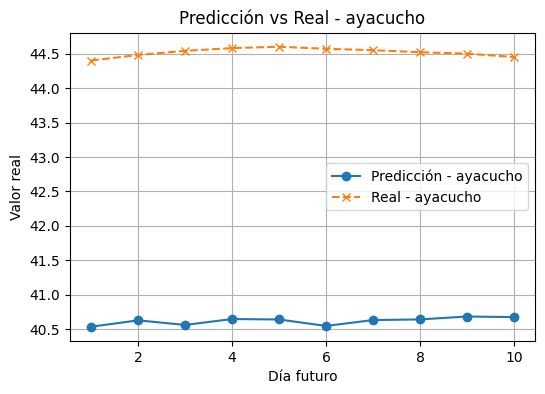

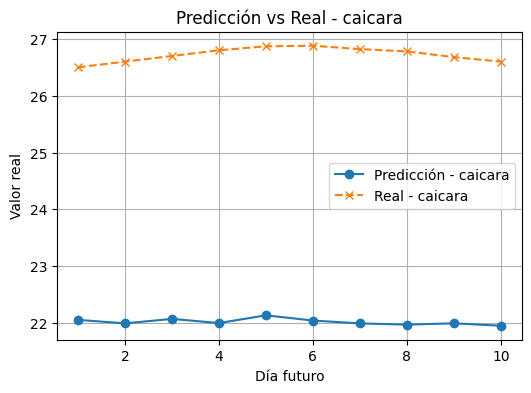

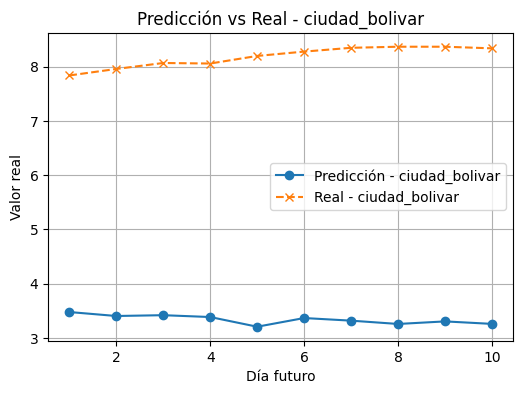

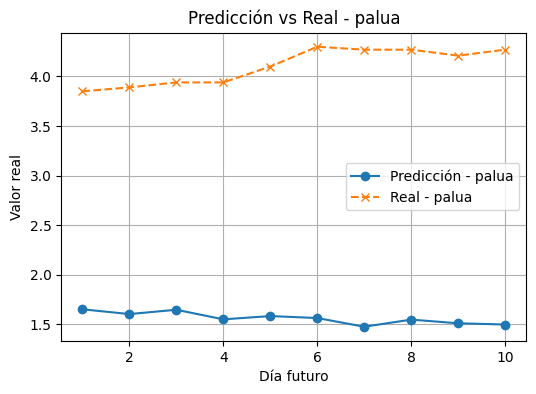

In [16]:
# Tomar la última secuencia del set de test para predecir los próximos 10 días
last_sequence = test_data[-sequence_length:]
last_sequence = last_sequence.reshape((1, sequence_length, test_data.shape[1]))

# Predecir los próximos 10 días para las 4 ciudades
future_pred = model.predict(last_sequence)  # shape: (1, 10, 4)
future_pred = future_pred[0]  # shape: (10, 4)

# Desnormalizar la salida para obtener los valores reales
future_pred_real = scaler.inverse_transform(
    np.hstack([future_pred, np.zeros((forecast_steps, 2))])  # Agregar columnas ficticias para desnormalizar
)[:, :4]  # Tomar solo las primeras 4 columnas

# Obtener los valores reales correspondientes (si están disponibles)
try:
    real_future = scaler.inverse_transform(
        np.hstack([test_data[-sequence_length: -sequence_length + forecast_steps, :4], np.zeros((forecast_steps, 2))])
    )[:, :4]
except Exception:
    real_future = None

print("Predicciones (10 días x 4 ciudades):")
print(future_pred_real)

if real_future is not None and real_future.shape == (10, 4):
    print("\nValores reales (si están disponibles):")
    print(real_future)
else:
    print("\nNo hay valores reales disponibles para los próximos 10 días.")

# Graficar
ciudades = ['ayacucho', 'caicara', 'ciudad_bolivar', 'palua']
dias = np.arange(1, forecast_steps + 1)

plt.figure(figsize=(10, 6))
for i, ciudad in enumerate(ciudades):
    plt.figure(figsize=(6, 4))
    plt.plot(dias, future_pred_real[:, i], marker='o', label=f'Predicción - {ciudad}')
    if real_future is not None and real_future.shape == (forecast_steps, 4):
        plt.plot(dias, real_future[:, i], marker='x', linestyle='--', label=f'Real - {ciudad}')
    plt.xlabel('Día futuro')
    plt.ylabel('Valor real')
    plt.title(f'Predicción vs Real - {ciudad}')
    plt.legend()
    plt.grid()
    plt.show()